     HASIL SIMULASI PERFORMA TERINTEGRASI      
Kecepatan Maksimal Tercapai : 103.17 km/jam
RPM Puncak Tercapai         : 2739.74 RPM
Torsi Puncak (saat start)   : 40000.00 Nm
---------------------------------------------------


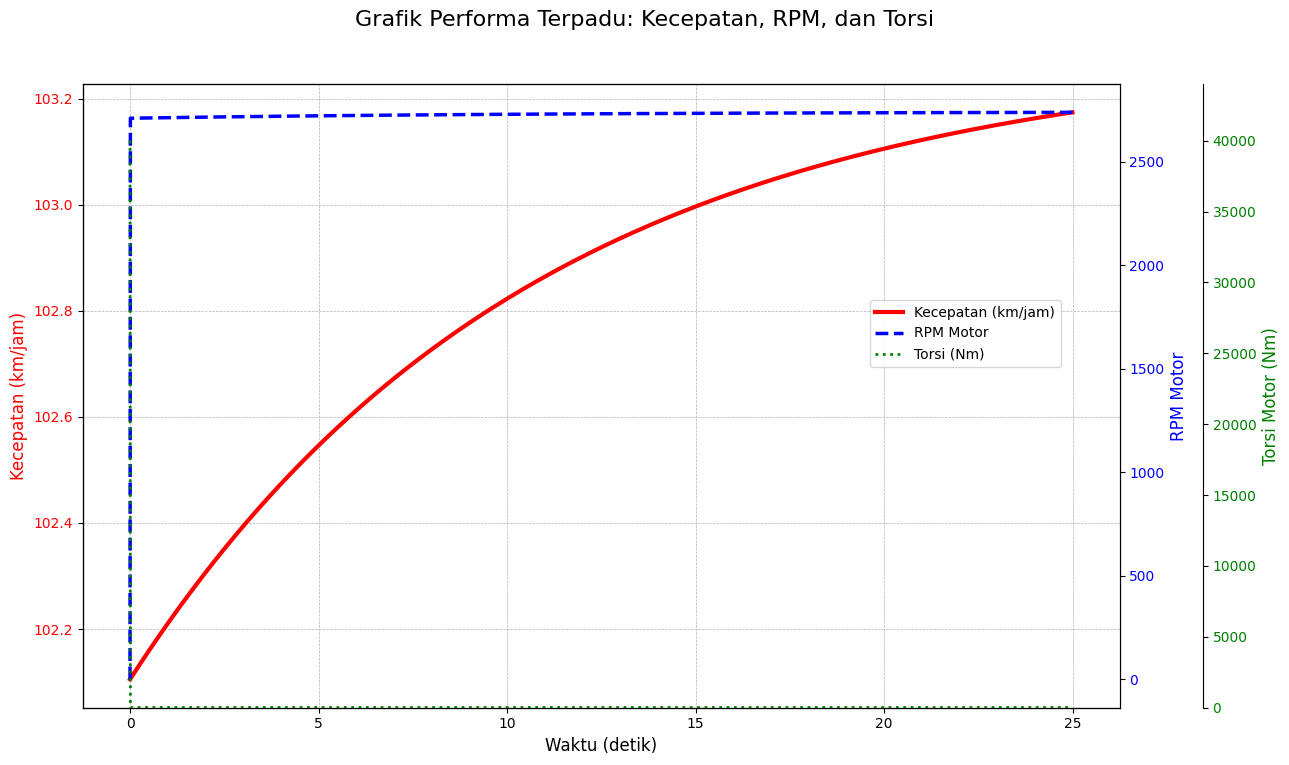

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# SEKSI 1: DEFINISI PARAMETER TERINTEGRASI
# =============================================================================

# 1.1. Parameter Kendaraan & Lingkungan
m_total = 120.0        # Massa total (kendaraan + pengendara) (kg)
r_roda = 0.264         # Radius roda (m), dari ban 60/80-17
g = 9.81               # Gravitasi (m/s^2)
C_rr = 0.015           # Koefisien hambatan gulir
rho_udara = 1.225      # Kepadatan udara (kg/m^3)
A_frontal = 0.4        # Luas area frontal (m^2)
C_d = 0.5              # Koefisien drag

# 1.2. Parameter Baterai & Kontroler
V_nominal = 72.0       # Tegangan nominal baterai (V)
I_max_controller = 160.0 # Arus puncak yang diizinkan kontroler (A)

# 1.3. Parameter Motor & Drivetrain
P_motor_watt = 4000.0  # Daya nominal motor (W)
G_rasio = 37.0 / 14.0  # Rasio gir (belakang/depan)
eff_total = 0.85       # Efisiensi total sistem (motor, kontroler, drivetrain)

# 1.4. Parameter Simulasi
dt = 0.01              # Interval waktu simulasi (detik)
t_simulasi_max = 25    # Durasi total simulasi (detik)

# =============================================================================
# SEKSI 2: INISIALISASI VARIABEL SIMULASI
# =============================================================================
t = 0.0                # Waktu
v_ms = 0.0             # Kecepatan dalam m/s

# List untuk menyimpan data hasil simulasi
log_t, log_v_kph, log_rpm, log_torsi = [], [], [], []

# =============================================================================
# SEKSI 3: LOOP SIMULASI PERFORMA TERINTEGRASI
# =============================================================================

while t < t_simulasi_max:
    # 3.1. Hitung Kecepatan Putar (Omega & RPM)
    # Kecepatan putar roda (rad/s)
    omega_roda = v_ms / r_roda
    # Kecepatan putar motor (rad/s)
    omega_motor = omega_roda * G_rasio
    # Konversi ke RPM
    rpm_motor = omega_motor * (60 / (2 * np.pi))

    # 3.2. Hitung Gaya Hambatan
    F_rolling = C_rr * m_total * g
    F_drag = 0.5 * rho_udara * A_frontal * C_d * (v_ms**2)
    F_resist = F_rolling + F_drag

    # 3.3. Hitung Torsi & Gaya Dorong
    # Daya listrik maksimum yang bisa ditarik, dibatasi oleh kontroler dan motor
    P_listrik_in = min(P_motor_watt / eff_total, V_nominal * I_max_controller)
    P_mekanik_out = P_listrik_in * eff_total
    
    # Hitung Torsi Motor (T = P / w)
    # Hindari pembagian dengan nol saat start
    if omega_motor > 0.1:
        torsi_motor = P_mekanik_out / omega_motor
    else:
        # Asumsi torsi awal yang sangat tinggi saat start (dibatasi daya)
        torsi_motor = P_mekanik_out / 0.1 

    # Hitung gaya dorong di roda
    F_dorong = (torsi_motor * G_rasio * eff_total) / r_roda

    # 3.4. Hitung Dinamika Kendaraan
    F_net = F_dorong - F_resist
    a = F_net / m_total
    
    # Update kecepatan
    v_ms += a * dt
    # Pastikan kecepatan tidak negatif
    v_ms = max(0, v_ms)

    # 3.5. Simpan data untuk plotting
    log_t.append(t)
    log_v_kph.append(v_ms * 3.6)
    log_rpm.append(rpm_motor)
    log_torsi.append(torsi_motor)
    
    # Increment waktu
    t += dt

# =============================================================================
# SEKSI 4: VISUALISASI GRAFIK TERPADU
# =============================================================================

# 4.1. Cetak Hasil Akhir
kecepatan_maksimal = max(log_v_kph)
rpm_maksimal = max(log_rpm)
torsi_puncak = max(log_torsi)

print("===================================================")
print("     HASIL SIMULASI PERFORMA TERINTEGRASI      ")
print("===================================================")
print(f"Kecepatan Maksimal Tercapai : {kecepatan_maksimal:.2f} km/jam")
print(f"RPM Puncak Tercapai         : {rpm_maksimal:.2f} RPM")
print(f"Torsi Puncak (saat start)   : {torsi_puncak:.2f} Nm")
print("---------------------------------------------------")


# 4.2. Konfigurasi Plot Tunggal dengan Multi-Sumbu
fig, ax1 = plt.subplots(figsize=(13, 8))
fig.suptitle('Grafik Performa Terpadu: Kecepatan, RPM, dan Torsi', fontsize=16)

# Sumbu Y pertama (kiri) untuk Kecepatan
color_v = 'red'
ax1.set_xlabel('Waktu (detik)', fontsize=12)
ax1.set_ylabel('Kecepatan (km/jam)', color=color_v, fontsize=12)
line_v = ax1.plot(log_t, log_v_kph, color=color_v, linewidth=3, label='Kecepatan (km/jam)')
ax1.tick_params(axis='y', labelcolor=color_v)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Sumbu Y kedua (kanan) untuk RPM
ax2 = ax1.twinx()
color_rpm = 'blue'
ax2.set_ylabel('RPM Motor', color=color_rpm, fontsize=12)
line_rpm = ax2.plot(log_t, log_rpm, color=color_rpm, linewidth=2.5, linestyle='--', label='RPM Motor')
ax2.tick_params(axis='y', labelcolor=color_rpm)

# Sumbu Y ketiga (kanan, dengan offset) untuk Torsi
ax3 = ax1.twinx()
# Atur posisi sumbu Y ketiga agar tidak tumpang tindih
ax3.spines['right'].set_position(('outward', 60))
color_torsi = 'green'
ax3.set_ylabel('Torsi Motor (Nm)', color=color_torsi, fontsize=12)
line_torsi = ax3.plot(log_t, log_torsi, color=color_torsi, linewidth=2, linestyle=':', label='Torsi (Nm)')
ax3.tick_params(axis='y', labelcolor=color_torsi)
# Atur batas y-axis untuk torsi agar lebih mudah dibaca
ax3.set_ylim(0, torsi_puncak * 1.1)

# Membuat legenda gabungan
lines = line_v + line_rpm + line_torsi
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', bbox_to_anchor=(0.95, 0.6))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
